In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sys
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import timeshap as ts
from timeshap import __version__
__version__

np.warnings = warnings

ROOT_DIR = Path('..')
sys.path.append(os.path.abspath(os.path.join('../Kha Huynh/Data cleansing')))
import DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score

import tensorflow as tf

# Data Preparation

In [3]:
# t0_df = pd.read_csv(df_final)
path_t0_df = ROOT_DIR / 'data/Model input data/t4_sequence.csv'
t0_df = pd.read_csv(path_t0_df)# t0_df

admission_t0 = t0_df[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

X_t0_train, X_t0_test, y_t0_train, y_t0_test = train_test_split(
    admission_t0.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
    admission_t0['IS_SEPSIS'],
    test_size=0.2,  # this means 20% test set
    stratify=admission_t0['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)
X_t0_train = t0_df.merge(X_t0_train[['SUBJECT_ID', 'HADM_ID']])
X_t0_train['count'] = X_t0_train.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
X_train_count = X_t0_train.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
y_t0_train = X_t0_train.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']

X_t0_test = t0_df.merge(X_t0_test[['SUBJECT_ID', 'HADM_ID']])
X_t0_test['count'] = X_t0_test.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
X_test_count = X_t0_test.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
y_t0_test = X_t0_test.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']

# # If you want to get the train and test set as dataframes:
train_t0_df = X_t0_train.drop(['count'], axis=1)
test_t0_df = X_t0_test.drop(['count'], axis=1)

# remove unrelated columns
X_t0_train = X_t0_train.drop(columns=["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'count'])
X_t0_test = X_t0_test.drop(columns=["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'count'])

In [4]:
# Feature scaling - Standardisation
scaler = StandardScaler()

X_t0_train = scaler.fit_transform(X_t0_train)
X_t0_test = scaler.transform(X_t0_test)

In [5]:
def ts_to_secs(X, X_count, Y):
    # X = X.T
    act_secs_labels = tf.one_hot(Y, 2)
    # act_secs_labels = Y.values

    number_of_secs = X_train_count.shape[0]
    secs_data = []

    k=0
    for i in X_count:
        secs_data.append(X[k:k+i, :])
        k = k+i

    secs_data = tf.ragged.constant(secs_data)
    # act_secs_labels = np.array(act_secs_labels)
    # act_secs_labels = tf.ragged.constant(act_secs_labels)
    return secs_data, act_secs_labels


In [6]:
def data_preparation():
  ## This Variable Defines the Size of Sliding Window
  ## ( e.g. 100 means in each snapshot we just consider 100 consecutive observations of each sensor)
  # w = 128 # 50 Equals to 1 second for MotionSense Dataset (it is on 50Hz samplig rate)
  ## Here We Choose Step Size for Building Different Snapshots from Time-Series Data
  ## ( smaller step size will increase the amount of the instances and higher computational cost may be incurred )
  # s = 10
  train_data, act_train = ts_to_secs(X_t0_train, X_train_count, y_t0_train)

  # s = 10
  test_data, act_test = ts_to_secs(X_t0_test, X_test_count, y_t0_test)


  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())

  return train_data, act_train, test_data, act_test

In [7]:
train_data, y_train, test_data, y_test = data_preparation()
act_label = ['NON-SEPSIS', 'SEPSIS']

[INFO] -- Shape of Training Sections:
tf.Tensor([36932     9    32], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([9233    8   32], shape=(3,), dtype=int64)


In [8]:
list(set(train_t0_df.columns)-set(['HADM_ID','IS_SEPSIS','SUBJECT_ID']))

['GENDER_NUM',
 'ITEMID_50878',
 'ITEMID_50821',
 'ITEMID_50893',
 'ITEMID_51301',
 'ITEMID_51221',
 'ITEMID_50862',
 'ITEMID_50820',
 'ITEMID_51256',
 'ITEMID_50804',
 'ITEMID_51275',
 'ITEMID_50863',
 'ITEMID_51493',
 'ITEMID_51248',
 'ITEMID_51265',
 'ITEMID_51003',
 'ITEMID_50902',
 'ITEMID_51274',
 'ITEMID_51237',
 'ITEMID_51279',
 'ITEMID_50912',
 'ITEMID_50970',
 'ITEMID_50813',
 'ITEMID_51222',
 'ITEMID_50983',
 'ITEMID_51244',
 'AGE',
 'ITEMID_50818',
 'ITEMID_51277',
 'ITEMID_50882',
 'ITEMID_51006',
 'ITEMID_50931']

In [7]:
train_X = np.zeros([len(tmp),9,32])

NameError: name 'tmp' is not defined

In [9]:
def scale(x):
  x = x.values
  x = np.array([x if not x ==-999 else float("nan") for x in x])
  x = (x-np.nanmean(x))/np.nanstd(x)
  return x

In [10]:
from copy import deepcopy

In [85]:
tmp_df  = deepcopy(train_t0_df)
test_tmp_df = deepcopy(test_t0_df)

In [86]:
for column in set(tmp_df.columns)-set(['HADM_ID','SUBJECT_ID','IS_SEPSIS','GENDER_NUM']):
  tmp_df[column] = scale(tmp_df[column])
  test_tmp_df[column] = scale(test_tmp_df[column])

In [64]:
# tmp_df = tmp_df.fillna(-999)
# test_tmp_df = test_tmp_df.fillna(-999)

In [65]:
Xtrain_tmp = tmp_df.groupby(['HADM_ID']).apply(lambda x:x[list(set(tmp_df.columns)-set(['HADM_ID','IS_SEPSIS','SUBJECT_ID']))].values)
Xtest_tmp = test_tmp_df.groupby(['HADM_ID']).apply(lambda x:x[list(set(test_tmp_df.columns)-set(['HADM_ID','IS_SEPSIS','SUBJECT_ID']))].values)

In [76]:
# Xtrain = np.stack([np.vstack([-999*np.ones([9,32]),ix])[-9:,:] for ix in Xtrain_tmp])
# Xtest = np.stack([np.vstack([-999*np.ones([9,32]),ix])[-9:,:] for ix in Xtest_tmp])

In [168]:
Xtrain = np.stack([np.vstack([np.zeros([9,32]),ix])[-9:,:] for ix in Xtrain_tmp])
Xtest = np.stack([np.vstack([np.zeros([9,32]),ix])[-9:,:] for ix in Xtest_tmp])

In [169]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential

In [182]:
inp = Input(shape=[32*9])
out = Dense(65)(inp)
#out = BatchNormalization()(out)
out_enc = Dense(64,activation='sigmoid')(out)
out = Dense(32*9)(out_enc)
model_enc = Model(inp, out_enc)
model = Model(inp,out)
model.compile(loss='mse',optimizer='adam')

In [186]:
model.fit(Xtrain.reshape([Xtrain.shape[0],9*32]),Xtrain.reshape([Xtrain.shape[0],9*32]),
epochs=10,batch_size=64)

Epoch 1/10
578/578 [==============================] - 1s 1ms/step - loss: 0.0182
Epoch 2/10
578/578 [==============================] - 1s 1ms/step - loss: 0.0181
Epoch 3/10
578/578 [==============================] - 1s 1ms/step - loss: 0.0180
Epoch 4/10
578/578 [==============================] - 1s 1ms/step - loss: 0.0179
Epoch 5/10
578/578 [==============================] - 1s 1ms/step - loss: 0.0178
Epoch 6/10
578/578 [==============================] - 1s 1ms/step - loss: 0.0177
Epoch 7/10
578/578 [==============================] - 1s 1ms/step - loss: 0.0176
Epoch 8/10
578/578 [==============================] - 1s 1ms/step - loss: 0.0176
Epoch 9/10
578/578 [==============================] - 1s 1ms/step - loss: 0.0176
Epoch 10/10
578/578 [==============================] - 1s 1ms/step - loss: 0.0174


In [187]:
Xrand = model_enc.predict(Xtrain.reshape([Xtrain.shape[0],9*32]))

1155/1155 [==============================] - 1s 836us/step


In [188]:
Xrand_test = model_enc.predict(Xtest.reshape([Xtest.shape[0],9*32]))

289/289 [==============================] - 0s 891us/step


In [224]:
from tensorflow.keras.layers import Conv1D, MaxPool1D
inp = Input(shape=[9*32,1])
out = inp

for ix in range(3):
  out = Conv1D(64,3,activation='relu')(inp)
  out = MaxPool1D(2)(out)
  out = BatchNormalization()(out)

out = Flatten()(out)
for ix in range(3):
  out = Dense(32,activation='relu')(out)

out = Dense(1,activation='sigmoid')(out)
model = Model(inp,out)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [225]:
Xtrain.reshape([Xtrain.shape[0],9*32,1]).shape,y_train[:,1].numpy().shape

((36932, 288, 1), (36932,))

In [233]:
model.fit(Xtrain.reshape([Xtrain.shape[0],9*32,1]), y_train[:,1].numpy(), epochs=10, batch_size=64, sample_weight=sample_weights,validation_split=0.1)

Epoch 1/10
520/520 [==============================] - 9s 17ms/step - loss: 0.6351 - accuracy: 0.6633 - val_loss: 0.7682 - val_accuracy: 0.4042
Epoch 2/10
520/520 [==============================] - 9s 17ms/step - loss: 0.6266 - accuracy: 0.4671 - val_loss: 0.8590 - val_accuracy: 0.4792
Epoch 3/10
520/520 [==============================] - 11s 21ms/step - loss: 0.6263 - accuracy: 0.4736 - val_loss: 0.8526 - val_accuracy: 0.5119
Epoch 4/10
520/520 [==============================] - 11s 21ms/step - loss: 0.6170 - accuracy: 0.4752 - val_loss: 0.8692 - val_accuracy: 0.3855
Epoch 5/10
520/520 [==============================] - 11s 22ms/step - loss: 0.6141 - accuracy: 0.4879 - val_loss: 0.8877 - val_accuracy: 0.4513
Epoch 6/10
520/520 [==============================] - 11s 22ms/step - loss: 0.6159 - accuracy: 0.4616 - val_loss: 0.8501 - val_accuracy: 0.4399
Epoch 7/10
520/520 [==============================] - 11s 21ms/step - loss: 0.6106 - accuracy: 0.4847 - val_loss: 0.8977 - val_accuracy: 0

In [234]:
model.evaluate(Xtest.reshape([Xtest.shape[0],9*32,1]),y_test[:,1].numpy(),sample_weight=sample_weights_test)

289/289 [==============================] - 1s 3ms/step - loss: 2603.2422 - accuracy: 0.8761


[2603.2421875, 0.8760966062545776]

In [199]:

clf = RandomForestClassifier(max_depth=7)
clf.fit(Xrand,y_train.numpy()[:,1].astype(int),sample_weight=sample_weights)

RandomForestClassifier(max_depth=7)

In [200]:
balanced_accuracy_score(clf.predict(Xrand),y_train.numpy()[:,1].astype(int),
sample_weight=sample_weights)

0.6794695701424145

In [201]:
balanced_accuracy_score(clf.predict(Xrand_test),y_test.numpy()[:,1].astype(int),
sample_weight=sample_weights_test)

0.24996965282833777

In [128]:
balanced_accuracy_score(clf.predict(Xtest.reshape([Xtest.shape[0],9*32])),y_test.numpy()[:,1].astype(int),
sample_weight=sample_weights_test)

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.49999999999996275

In [129]:
clf.predict(Xtest.reshape([Xtest.shape[0],9*32])).sum()

0

In [120]:
confusion_matrix(clf.predict(Xtest.reshape([Xtest.shape[0],9*32])),y_test.numpy()[:,1].astype(int))

array([[8239,  993],
       [   0,    1]], dtype=int64)

In [109]:
clf.score(Xtrain.reshape([Xtrain.shape[0],9*32]),y_train.numpy()[:,1].astype(int),sample_weight=sample_weights)

0.8923573112701273

In [98]:
clf.score(Xtest.reshape([Xtest.shape[0],9*32]),y_test.numpy()[:,1].astype(int),sample_weight=sample_weights_test)

0.500217105521831

In [166]:
Xtest

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.38939380e-01, -9.99000000e+02, ...,
         -5.72384029e-01,  9.65391033e-01, -6.15022139e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

In [16]:
from tensorflow.keras.layers import Input,LSTM,GRU,Dropout,BatchNormalization,Dense,TimeDistributed, Masking, Flatten, Bidirectional
from tensorflow.keras.models import Model

In [156]:
inp = Input(shape=[9,32])
out = Masking(mask_value=-999.0)(inp)
#out = Bidirectional(GRU(64, return_sequences=True,activation='swish'))(out)
#out = TimeDistributed(Dense(64,activation='relu'))(out)
out = Bidirectional(GRU(64,activation='swish'))(out)
out = Dense(1,activation='sigmoid')(out)
model = Model(inp, out)

In [17]:
from sklearn.impute import SimpleImputer

In [84]:
model.predict(np.random.random([1,9,32]))

NameError: name 'model' is not defined

In [87]:
columns_to_impute = [ix for ix in train_t0_df.columns if 'ITEM' in ix]

In [88]:
imputer = SimpleImputer(strategy='mean', missing_values=-999)

In [89]:
imputer.fit(train_t0_df[columns_to_impute])
train_t0_df[columns_to_impute] = imputer.transform(train_t0_df[columns_to_impute])

In [90]:
train_t0_df

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50813,ITEMID_50818,ITEMID_50820,ITEMID_50821,...,ITEMID_51244,ITEMID_51248,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493
0,3,145834,76,0,0,23.000000,4.300000,40.000000,7.350000,20.000000,...,8.000000,29.100000,81.000000,282.000000,13.500000,30.700000,15.10000,3.440000,12.700000,12.058957
1,3,145834,76,0,0,28.000000,8.800000,28.000000,7.590000,313.000000,...,14.921071,28.900000,76.528675,190.000000,15.700000,58.300000,15.00000,2.700000,11.300000,12.058957
2,3,145834,76,0,0,13.000000,8.000000,28.000000,7.260000,329.000000,...,14.921071,29.600000,76.528675,253.000000,15.600000,46.400000,15.30000,2.790000,19.100000,12.058957
3,4,185777,47,1,0,25.149756,2.740949,43.919452,7.349502,242.033509,...,6.900000,30.400000,89.600000,207.000000,12.300000,31.300000,13.60000,3.800000,9.700000,12.058957
4,9,150750,41,0,0,25.149756,2.740949,43.919452,7.349502,242.033509,...,41.600000,28.300000,50.100000,258.000000,12.700000,21.700000,13.40000,5.460000,7.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53432,99983,117390,78,0,0,25.149756,2.740949,43.919452,7.349502,242.033509,...,14.921071,32.300000,76.528675,253.000000,13.400000,27.000000,12.70000,4.210000,7.500000,12.058957
53433,99995,137810,88,1,0,33.000000,1.100000,33.000000,7.590000,376.000000,...,14.921071,30.237789,76.528675,249.438695,19.700000,35.500000,14.95155,3.911541,11.898176,12.058957
53434,99995,137810,88,1,0,36.000000,1.100000,52.000000,7.430000,382.000000,...,14.921071,30.237789,76.528675,249.438695,16.456259,34.756533,14.95155,3.911541,11.898176,12.058957
53435,99999,113369,64,1,0,24.000000,3.100000,40.000000,7.360000,234.000000,...,14.921071,30.237789,76.528675,249.438695,16.456259,34.756533,14.95155,3.911541,11.898176,12.058957


In [22]:
train_t0_df

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50813,ITEMID_50818,ITEMID_50820,ITEMID_50821,...,ITEMID_51244,ITEMID_51248,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493
0,3,145834,76,0,0,23.000000,4.300000,40.000000,7.350000,20.000000,...,8.000000,29.100000,81.000000,282.000000,13.500000,30.700000,15.10000,3.440000,12.700000,12.058957
1,3,145834,76,0,0,28.000000,8.800000,28.000000,7.590000,313.000000,...,14.921071,28.900000,76.528675,190.000000,15.700000,58.300000,15.00000,2.700000,11.300000,12.058957
2,3,145834,76,0,0,13.000000,8.000000,28.000000,7.260000,329.000000,...,14.921071,29.600000,76.528675,253.000000,15.600000,46.400000,15.30000,2.790000,19.100000,12.058957
3,4,185777,47,1,0,25.149756,2.740949,43.919452,7.349502,242.033509,...,6.900000,30.400000,89.600000,207.000000,12.300000,31.300000,13.60000,3.800000,9.700000,12.058957
4,9,150750,41,0,0,25.149756,2.740949,43.919452,7.349502,242.033509,...,41.600000,28.300000,50.100000,258.000000,12.700000,21.700000,13.40000,5.460000,7.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53432,99983,117390,78,0,0,25.149756,2.740949,43.919452,7.349502,242.033509,...,14.921071,32.300000,76.528675,253.000000,13.400000,27.000000,12.70000,4.210000,7.500000,12.058957
53433,99995,137810,88,1,0,33.000000,1.100000,33.000000,7.590000,376.000000,...,14.921071,30.237789,76.528675,249.438695,19.700000,35.500000,14.95155,3.911541,11.898176,12.058957
53434,99995,137810,88,1,0,36.000000,1.100000,52.000000,7.430000,382.000000,...,14.921071,30.237789,76.528675,249.438695,16.456259,34.756533,14.95155,3.911541,11.898176,12.058957
53435,99999,113369,64,1,0,24.000000,3.100000,40.000000,7.360000,234.000000,...,14.921071,30.237789,76.528675,249.438695,16.456259,34.756533,14.95155,3.911541,11.898176,12.058957


In [157]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:

def compute_sample_weights(y):
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    sample_weights = class_weights[y]
    return sample_weights

In [94]:
sample_weights = compute_sample_weights(y_train.numpy()[:,1].astype(int))
sample_weights_test = compute_sample_weights(y_test.numpy()[:,1].astype(int))

In [93]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras

checkpointer = ModelCheckpoint(filepath = 'weights_best_t4_GRU.hdf5', save_best_only = True, monitor='accuracy', mode='max')
early_stop = keras.callbacks.EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 3, restore_best_weights=True)
callbacks_list = [early_stop, checkpointer]

In [158]:
model.fit(Xtrain,y_train.numpy()[:,1], sample_weight=sample_weights, batch_size=32, epochs=10, callbacks=callbacks_list)

Epoch 1/10
1155/1155 [==============================] - 35s 28ms/step - loss: 0.6985 - accuracy: 0.4694
Epoch 2/10
1155/1155 [==============================] - 37s 32ms/step - loss: 0.6918 - accuracy: 0.5130
Epoch 3/10
   1/1155 [..............................] - ETA: 23s - loss: 0.7350 - accuracy: 0.3438

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1155/1155 [==============================] - 37s 32ms/step - loss: 0.6893 - accuracy: 0.4799
Epoch 4/10
1155/1155 [==============================] - 35s 30ms/step - loss: 0.6859 - accuracy: 0.4910
Epoch 5/10
1155/1155 [==============================] - 37s 32ms/step - loss: 0.6833 - accuracy: 0.5230
Epoch 6/10
1155/1155 [==============================] - 37s 32ms/step - loss: 0.6755 - accuracy: 0.5195
Epoch 7/10
1155/1155 [==============================] - 38s 33ms/step - loss: 0.6683 - accuracy: 0.5625
Epoch 8/10
1155/1155 [==============================] - 40s 35ms/step - loss: 0.6609 - accuracy: 0.5429
Epoch 9/10
1155/1155 [==============================] - 40s 34ms/step - loss: 0.6520 - accuracy: 0.5592
Epoch 10/10
1155/1155 [==============================] - 40s 34ms/step - loss: 0.6424 - accuracy: 0.5653


In [36]:
from tensorflow.keras.models import Sequential
clf = RandomForestClassifier()

In [37]:
model_dense = Sequential()

for _ in range(4):
  model_dense.add(Dense(64))
model_dense.add(Dense(1,activation='sigmoid'))

model_dense.compile(loss='bce',optimizer='adam')


array([[-9.99000000e+02, -9.99000000e+02, -9.99000000e+02, ...,
        -9.99000000e+02, -9.99000000e+02, -9.99000000e+02],
       [-9.99000000e+02, -9.99000000e+02, -9.99000000e+02, ...,
         5.30311526e-01, -6.43999771e-02, -2.86171761e-01],
       [-9.99000000e+02, -9.99000000e+02, -9.99000000e+02, ...,
        -9.99000000e+02,  9.85181161e-01, -9.99000000e+02],
       ...,
       [-9.99000000e+02, -9.99000000e+02, -9.99000000e+02, ...,
        -9.99000000e+02, -5.39210492e-01, -9.99000000e+02],
       [-9.99000000e+02, -9.99000000e+02, -9.99000000e+02, ...,
        -9.99000000e+02, -2.64320194e-01, -9.99000000e+02],
       [-9.99000000e+02, -9.99000000e+02, -9.99000000e+02, ...,
        -9.99000000e+02, -2.69149365e-02, -9.99000000e+02]])

In [32]:
clf.score(model_encoder(Xtrain).numpy(),y_train.numpy()[:,1])

0.6509260262103325

In [27]:
# Plotting ROC curve to determine the threshold
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=11)
    plt.ylabel('True Positive Rate (Recall)', fontsize=11)
    plt.grid(True)

# Model Training t4

In [159]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding, Input, MaxPooling2D
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np
# from keras.layers.convolutional import Conv1D
from keras.models import Sequential

max_seq = train_data.bounding_shape()[-1]
def LSTM_model():
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, 32], dtype=tf.float32, ragged=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64,return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(32))
    model.add(Dropout(d))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         82432     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_47 (Dense)            (None, 25)               

In [43]:
def get_class_weights():
  label_counts = y_t0_train.value_counts()
  label_proportions = label_counts / len(y_t0_train)*100
  # Calculate class weights
  class_weights = {0: 1 / (label_proportions[0] / 100), 1: 1 / (label_proportions[1] / 100)}

  # Round the class weights to the desired precision (optional)
  class_weights = {key: round(weight, 4) for key, weight in class_weights.items()}
  return class_weights
from sklearn.utils.class_weight import compute_class_weight


get_class_weights()

{0: 1.1207, 1: 9.2841}

In [44]:
sample_weights = compute_sample_weights(y_train.numpy()[:,1].astype(int))

NameError: name 'compute_sample_weights' is not defined

In [162]:
checkpointer = ModelCheckpoint(filepath = 'weights_best_t4.hdf5', save_best_only = True, monitor='accuracy', mode='max')
early_stop = keras.callbacks.EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 3, restore_best_weights=True)
callbacks_list = [early_stop, checkpointer]
m = model.fit(Xtrain,y_train,
              sample_weight=sample_weights,
              epochs=40, batch_size=64, verbose=1, #validation_split=0.1,
               callbacks=callbacks_list)

Epoch 1/40
578/578 [==============================] - 49s 77ms/step - loss: 0.6951 - accuracy: 0.4830
Epoch 2/40
381/578 [==================>...........] - ETA: 17s - loss: 0.6974 - accuracy: 0.4194

: 

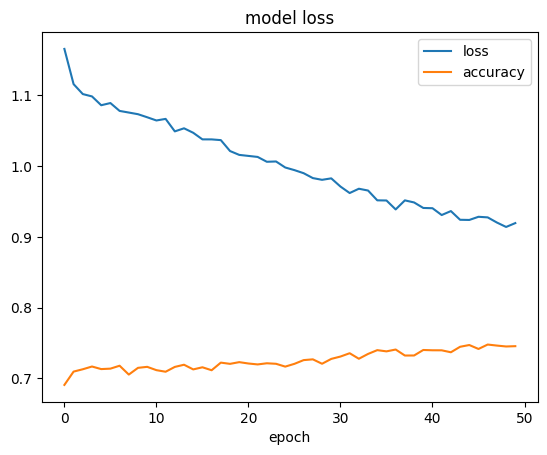

In [15]:
import matplotlib.pyplot as plt
plt.plot(m.history['loss'])
plt.plot(m.history['accuracy'])
plt.title('model loss')
# plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'], loc='upper right')
plt.show()

In [8]:
print("Inference:")
from keras.models import load_model
model = load_model("weights_best_t4.hdf5")

Inference:


In [9]:
# Plotting ROC curve to determine the threshold
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=11)
    plt.ylabel('True Positive Rate (Recall)', fontsize=11)
    plt.grid(True)

289/289 [==============================] - 2s 3ms/step
AUC = 0.7528


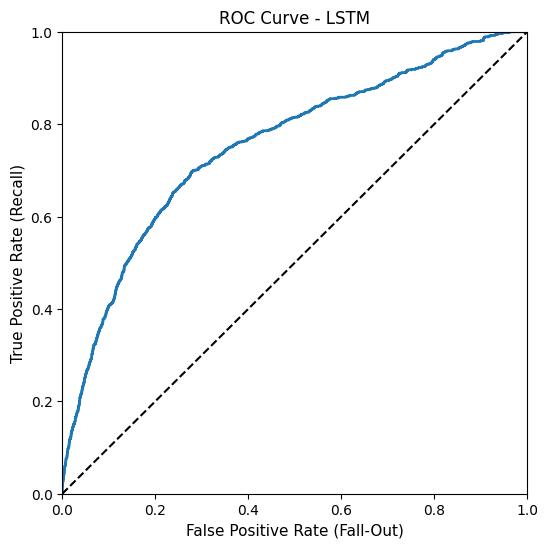

In [10]:
# Predict the test set using the best random forest regressor
y_pred = model.predict(test_data)

# Plotting ROC curve
fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(np.argmax(y_test, axis=1), y_pred[:, 1], pos_label=1)
# fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(y_test, y_pred, pos_label=1)
auc_t0_rf = auc(fpr_rf_test, tpr_rf_test)
print("AUC = {:.4f}".format(auc_t0_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_rf_test, tpr_rf_test)
plt.title("ROC Curve - LSTM")
plt.grid(False)
plt.show()

In [11]:
def print_results(M, X_train, Y_train, X_test, Y_test):
    # np.set_printoptions(suppress=True)
    # result1 = M.evaluate(X, Y, verbose = 2)
    # act_acc = np.round(result1[1]*100,2)
    # print("***[RESULT]*** ACT Accuracy: "+str(act_acc))
    Y_train = np.argmax(Y_train, axis=1)
    Y_test = np.argmax(Y_test, axis=1)

    preds_train = M.predict(X_train)
    preds_train = np.argmax(preds_train, axis=1)
    conf_mat_train = confusion_matrix(Y_train, preds_train)
    # conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    preds_test = M.predict(X_test)
    preds_test = np.argmax(preds_test, axis=1)
    conf_mat_test = confusion_matrix(Y_test, preds_test)
    # conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    print("***[RESULT]*** ACT  Confusion Matrix")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    x_labels = ["Predicted\nNon-Sepsis", "Predicted\nSepsis"]
    y_labels = ["Actual Non-Sepsis", "Actual Sepsis"]
    sns.heatmap(conf_mat_train, fmt='d', annot=True, xticklabels=x_labels, yticklabels=y_labels, ax=axes[0])
    sns.heatmap(conf_mat_test, fmt='d', annot=True, xticklabels=x_labels, yticklabels=y_labels, ax=axes[1])

    axes[0].set_title("CM in training set", fontsize = 10)
    axes[1].set_title("CM in test set", fontsize = 10)
    axes[0].tick_params(labelsize=9)
    axes[1].tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()

    f1_train = f1_score(Y_train, preds_train)
    f1_test = f1_score(Y_test, preds_test)
    acc_train = balanced_accuracy_score(Y_train, preds_train)
    acc_test = balanced_accuracy_score(Y_test, preds_test)
    # Computing precision and recall
    precision_train = precision_score(Y_train, preds_train)
    precision_test = precision_score(Y_test, preds_test)
    recall_train = recall_score(Y_train, preds_train)
    recall_test = recall_score(Y_test, preds_test)
    # table = pd.DataFrame({'F1-Score':[f1_train, f1_test], 'Balanced Acc':[acc_train, acc_test],
    #                      'Precision':[precision_train, precision_test], 'Recall':[recall_train, recall_test]},
    #                      index=['Train', 'Test'])

    table = pd.DataFrame({'Train':[acc_train, precision_train, recall_train, f1_train], 'Test':[acc_test, precision_test, recall_test, f1_test]},
                         index=['Balanced Acc', 'Precision', 'Recall', 'F1-Score'])
    print(table)

289/289 [==============================] - 1s 3ms/step
***[RESULT]*** ACT  Confusion Matrix


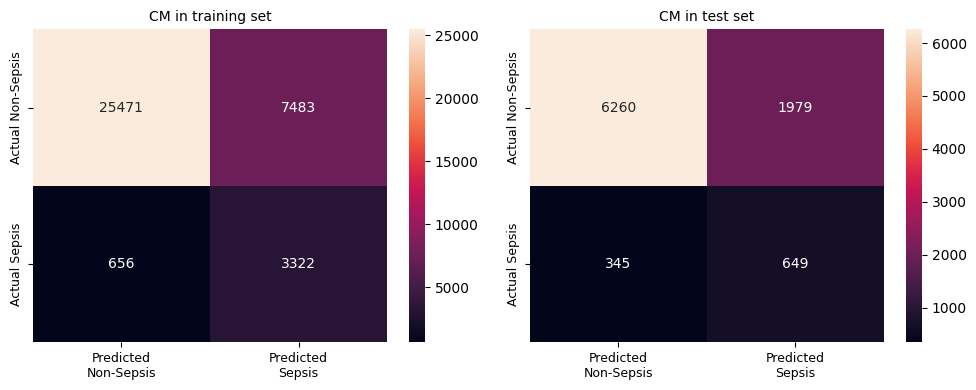

                 Train      Test
Balanced Acc  0.804009  0.706359
Precision     0.307450  0.246956
Recall        0.835093  0.652918
F1-Score      0.449435  0.358366


In [12]:
print_results(model, train_data, y_train, test_data, y_test)

# TimeSHAP

Model entry point

In [20]:
f = lambda x: model.predict(x)[:, 1]
raw_model_features = train_t0_df.columns
model_features = [f"p_normalize_{x}" for x in np.delete(raw_model_features, [0,1,4])]

In [21]:
d_train_normalized = pd.concat([train_t0_df, pd.DataFrame(X_t0_train, columns=model_features)], axis=1)
d_test_normalized = pd.concat([test_t0_df, pd.DataFrame(X_t0_test, columns=model_features)], axis=1)

Baseline event

In [22]:
from timeshap.utils import calc_avg_event
average_event = calc_avg_event(d_train_normalized, numerical_feats=model_features, categorical_feats=[])

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [42]:
average_event

,p_AGE_normalize,p_GENDER_NUM_normalize,p_ITEMID_50804_normalize,p_ITEMID_50813_normalize,p_ITEMID_50818_normalize,p_ITEMID_50820_normalize,p_ITEMID_50821_normalize,p_ITEMID_50862_normalize,p_ITEMID_50863_normalize,p_ITEMID_50878_normalize,...,p_ITEMID_51244_normalize,p_ITEMID_51248_normalize,p_ITEMID_51256_normalize,p_ITEMID_51265_normalize,p_ITEMID_51274_normalize,p_ITEMID_51275_normalize,p_ITEMID_51277_normalize,p_ITEMID_51279_normalize,p_ITEMID_51301_normalize,p_ITEMID_51493_normalize
0,0.187396,-0.850357,-0.842224,-0.848199,-0.842027,-0.890172,-0.832588,-0.501391,-0.611267,-0.482339,...,-0.913225,0.713598,-0.91318,0.562068,0.887343,0.898833,0.715028,0.715364,0.702611,-0.298054


In [ ]:
from timeshap.utils import calc_avg_sequence
average_sequence = calc_avg_sequence(d_train_normalized, numerical_feats=model_features, categorical_feats=[],model_features=model_features, entity_col='HADM_ID')

Average score over baseline

In [23]:
print("Inference:")
from keras.models import load_model
model = load_model("weights_best_t4.hdf5")

Inference:


In [44]:
model.predict(test_data).shape

289/289 [==============================] - 2s 5ms/step


(9233, 2)

In [ ]:
from timeshap.utils import get_avg_score_with_avg_event
avg_score_over_len = get_avg_score_with_avg_event(f, average_event, top=480)

## Local Explanations

In [133]:
ids_for_test = [183628, 116009, 107064, 109235] # first 2 hadm_id are sepsis case, last 2 are non-sepsis
pos_x_pd = d_test_normalized[d_test_normalized['HADM_ID'].isin(ids_for_test)]
labels = d_test_normalized[d_test_normalized.HADM_ID.isin(ids_for_test)].drop_duplicates(['HADM_ID'])[['HADM_ID', 'IS_SEPSIS']]

# select model features only
# pos_x_data = pos_x_pd[model_features]
# convert the instance to numpy so TimeSHAP receives it
pos_x_data = [np.expand_dims(pos_x_pd[pos_x_pd.HADM_ID==x][model_features].to_numpy().copy(), axis=0) for x in ids_for_test]

In [25]:
_, df_desc_labitems,_ = dataLoader.load_descriptions()

In [26]:
plot_feats_1 = {x:x[12:] for x in model_features[:2]}
plot_feats_2 = {x: df_desc_labitems[df_desc_labitems.ITEMID == int(x[19:])].LABEL.values[0] for x in model_features[2:]}
plot_feats = {**plot_feats_1, **plot_feats_2}

In [130]:
from timeshap.explainer import local_report, local_pruning, local_feat
from timeshap.plot import plot_feat_barplot, plot_global_feat, feature_level
import altair  as alt
sequence_id_feat = 'HADM_ID'

def plot_local_features(ids_for_test, pos_x_data, labels):
  objects = len(ids_for_test)
  plots = []
  for pos_id in list(range(0,objects)):
    hadm_id = ids_for_test[pos_id]
    pos_x = pos_x_data[pos_id]
    label = 'SEPSIS' if labels[labels.HADM_ID == hadm_id]['IS_SEPSIS'].values==1 else 'NON-SEPSIS'
    pruning_dict = {'tol': 0.025,}
    coal_plot_data, coal_prun_idx = local_pruning(f, pos_x, pruning_dict, average_event, hadm_id, sequence_id_feat, False)
    # coal_prun_idx is in negative terms
    pruning_idx = pos_x.shape[1] + coal_prun_idx

    feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats}
    feature_data = local_feat(f, pos_x, feature_dict, hadm_id, sequence_id_feat, average_event, pruning_idx)
    feat_plot_0 = plot_feat_barplot(feature_data, feature_dict.get('top_feats'), feature_dict.get('plot_features'))
    feat_plot_0 = feat_plot_0.properties(width=500, height = {'step': 15}, title=f'HADM_ID: {hadm_id}, {label}')
    feat_plot_0 = feat_plot_0.encode(
        x=alt.X('Shapley Value', type='quantitative', scale=alt.Scale(domain=[-0.5, 0.5]))
    )
    plots.append(feat_plot_0)
  return plots

In [134]:
feat_plots = plot_local_features(ids_for_test, pos_x_data, labels)

1000/1000 [==============================] - 2s 2ms/step


In [135]:
(feat_plots[0] | feat_plots[1]) & (feat_plots[2] | feat_plots[3])

alt.VConcatChart(...)

## Global Explanation

In [75]:
d_test_normalized['timestamp'] = d_test_normalized.groupby(['SUBJECT_ID', 'HADM_ID']).cumcount()
d_test_normalized.timestamp = d_test_normalized.timestamp.astype(int)

In [143]:
from timeshap.explainer import prune_all, pruning_statistics, event_explain_all, feat_explain_all
from timeshap.plot import plot_global_event, plot_global_feat

pos_dataset = d_test_normalized
schema = list(pos_dataset.columns)
time_feat = 'timestamp'

In [ ]:
pruning_dict = {'tol': [0.05, 0.075], 'path': 'outputs/prun_all_tf.csv'}
prun_indexes = prune_all(f, pos_dataset, pruning_dict, average_event, model_features, schema, sequence_id_feat, time_feat)
# pruning_stats = pruning_statistics(prun_indexes, pruning_dict.get('tol'))
# pruning_stats

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 26s 26s/step


In [78]:
# prun_indexes = pd.read_csv('prun_all_tf.csv')
prun_indexes

In [1]:
event_dict = {'rs': 42, 'nsamples': 32000}
event_data = event_explain_all(f, pos_dataset, event_dict, prun_indexes, average_event, model_features, schema, sequence_id_feat, time_feat)
event_global_plot = plot_global_event(event_data)
event_global_plot

NameError: ignored